In [73]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

### Instructions
For this part, fill in the required code and make the notebook work. This wll be very similar to the Skip-Gram model, but a little more difficult. Look for the """ FILL IN """ string to guide you.

In [74]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [75]:
!du -h text8

 95M	text8


In [76]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [77]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [78]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [79]:
words = TOKENIZER(text)
f = Counter(words)

In [80]:
len(words)

17005207

In [81]:
# Do a very crude filter on the text which removes all very popular words.
text = [word for word in words if f[word] > 5]

In [82]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [83]:
VOCAB = build_vocab_from_iterator([text])

In [84]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [85]:
stoi['as']

11

In [86]:
# Total number of words.
len(stoi)

63641

In [87]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [88]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [89]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [90]:
len(train_dataset)

7846946

In [91]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [92]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [93]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [94]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [95]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        # Get the left and right tokens.
        start = max(0, i-m)
        left_tokens = dataset[start:i]
        
        end = min(len(dataset)-1, i+m)
        right_tokens = dataset[i+1:end+1]
        
        # Check these are the same length, and if so use them to add a row of data. This should be a list like.
        # [a, c, b] where b is the center word.
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = token
                        
            x_list.extend(
                [w_context + [wc]]
            )
            
    return x_list

In [96]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [97]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [98]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [99]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 202, 5],
 [5, 1, 202],
 [202, 3133, 1],
 [1, 48, 3133],
 [3133, 56, 48],
 [48, 173, 56],
 [56, 107, 173],
 [173, 741, 107]]

In [100]:
len(train_x_list)// BATCH_SIZE

32579

In [101]:
# The number of things of BATCH_SIZE = 512.
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [102]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [103]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [104]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [105]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 3)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:,0:2], x[:,2]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, D) and this is what we get.
        
        # (N, 2, D)
        a = self.A(w_context)
        
        # (N, D)
        a_avg = torch.mean(a, dim=1)
        
        # Each of these is (N, D) since each target has 1 word.
        b = self.B(wc)
                
        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = torch.sum(a_avg * b, dim=1)
                
        return logits

In [106]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [107]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [108]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [109]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [110]:
validate_embeddings(model, valid_ids, itos)

money: pappas, allowances, nippon, tagged, invaders, atypical, fibreglass, levine, tasteless, terminology
lion: lanchester, tem, fetuses, crests, sharia, camino, freyja, stradonitz, gpp, effect
africa: hawkwind, gilbertese, shrines, comically, tropospheric, rsta, artefacts, blok, theorizing, volsunga
musician: frequented, fewest, basis, butterfield, hallucinogenic, applicability, mihdhar, snap, consular, lian
dance: equator, temporally, liberating, platypus, broly, guillermo, enacting, perpignan, marbles, swedes




### Train the model

In [117]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
        
        # Zero the gradient so they don't accumulate.
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        #print("Batch size: ", batch_size)
        negative_samples = torch.multinomial(p, batch_size*K, replacement=True)
        #print("negative_samples: ", negative_samples.size())
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc =x_batch[:,0:2].to('cpu'), negative_samples
        
        #print("w_context: ", w_context.size())
        #print("wc: ", wc.size())
        
        """
        if w_context looks like below (batch_size = 3)
        [
        (a, b),
        (c, d),
        (e, f)
        ] and K = 2 we'd like to get:
        
        [
        (a, b),
        (a, b),
        (c, d), 
        (c, d),
        (e, f),
        (e, f)
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ])
        #print("w_context: ", w_context.size())
        # Remove the last dimension 1.
        wc = wc.view(wc.size()[0],1)
        #print("wc: ", wc.size())
        # Get the negative samples. This should be (N * K, 3).
        # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU.
        x_batch_negative = torch.concat([w_context, wc], axis=1).to(DEVICE)
        #print("x_batch_negative: ", x_batch_negative.shape)      
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        # Look at the Skip-Gram notebook.
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        # Get the new loss.
        total_loss += loss.item()
        # Update the batch count.
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [118]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]/var/folders/f8/mb2zprsj5wj1n9ygh0fcr3nw0000gn/T/ipykernel_3925/750430753.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
2it [00:00,  2.95it/s]

| epoch   1 |     0/32580 batches | loss    1.330 
money: able, idea, fact, seen, time, practice, existence, way, well, nine
lion: effect, articles, elected, presented, result, vote, movies, musician, eight, lake
africa: europe, america, india, east, asia, china, kingdom, nine, coast, west
musician: singer, actor, author, actress, composer, writer, nine, basis, seven, born
dance: music, original, addition, history, culture, largest, whole, rock, parts, style




502it [00:47,  9.69it/s]

| epoch   1 |   500/32580 batches | loss    1.380 
money: able, idea, fact, seen, time, practice, way, well, nine, existence
lion: effect, articles, elected, presented, result, vote, movies, musician, eight, town
africa: europe, america, india, east, asia, china, kingdom, coast, nine, west
musician: singer, actor, author, actress, composer, writer, nine, seven, born, basis
dance: music, original, addition, history, culture, whole, largest, parts, rock, style




1002it [01:32,  9.89it/s]

| epoch   1 |  1000/32580 batches | loss    1.376 
money: able, idea, time, fact, seen, practice, existence, way, well, nine
lion: effect, articles, elected, presented, result, musician, vote, movies, town, eight
africa: europe, america, east, india, asia, china, kingdom, coast, japan, west
musician: singer, actor, author, actress, composer, writer, nine, seven, born, basis
dance: music, original, addition, history, culture, whole, traditional, largest, rock, parts




1502it [02:18,  9.85it/s]

| epoch   1 |  1500/32580 batches | loss    1.373 
money: able, time, idea, fact, seen, practice, existence, way, well, return
lion: articles, effect, elected, result, presented, eight, musician, town, vote, movies
africa: europe, america, east, india, china, asia, kingdom, coast, japan, west
musician: singer, actor, actress, author, composer, writer, nine, seven, born, politician
dance: music, original, addition, history, whole, culture, rock, traditional, largest, parts




2002it [03:04,  9.68it/s]

| epoch   1 |  2000/32580 batches | loss    1.369 
money: able, time, idea, fact, seen, practice, existence, way, well, return
lion: articles, effect, elected, presented, result, eight, musician, town, vote, emperor
africa: europe, america, india, east, asia, china, kingdom, japan, coast, germany
musician: singer, actor, actress, author, composer, writer, nine, seven, politician, born
dance: music, addition, original, history, whole, culture, largest, traditional, rock, parts




2502it [03:50,  9.61it/s]

| epoch   1 |  2500/32580 batches | loss    1.363 
money: able, time, idea, fact, seen, practice, existence, way, well, return
lion: articles, effect, elected, presented, eight, result, musician, vote, town, movies
africa: europe, india, america, east, asia, china, kingdom, japan, coast, germany
musician: singer, actor, actress, author, composer, writer, nine, politician, born, seven
dance: music, original, addition, whole, history, culture, largest, rock, traditional, style




3002it [04:37,  8.97it/s]

| epoch   1 |  3000/32580 batches | loss    1.366 
money: able, time, idea, fact, practice, seen, existence, way, well, return
lion: articles, effect, elected, presented, result, eight, musician, vote, directors, movies
africa: europe, india, america, east, china, asia, kingdom, japan, coast, germany
musician: singer, actor, actress, author, composer, writer, politician, nine, born, seven
dance: music, addition, original, whole, culture, largest, history, traditional, rock, parts




3501it [05:23,  9.87it/s]

| epoch   1 |  3500/32580 batches | loss    1.363 
money: able, time, idea, fact, practice, seen, existence, way, well, return
lion: articles, elected, effect, result, presented, eight, five, musician, vote, movies
africa: europe, india, america, china, east, asia, kingdom, japan, coast, germany
musician: singer, actor, actress, author, composer, writer, politician, born, eight, nine
dance: music, original, addition, whole, culture, largest, rock, history, traditional, parts




4001it [06:09, 10.09it/s]

| epoch   1 |  4000/32580 batches | loss    1.363 
money: able, time, idea, practice, fact, existence, way, seen, well, return
lion: elected, articles, effect, result, presented, five, eight, four, vote, musician
africa: europe, india, america, east, china, asia, kingdom, japan, coast, germany
musician: singer, actor, actress, composer, author, writer, politician, nine, born, seven
dance: music, original, addition, whole, history, culture, traditional, rock, same, largest




4502it [06:55,  9.44it/s]

| epoch   1 |  4500/32580 batches | loss    1.356 
money: able, idea, time, practice, fact, way, existence, seen, return, nine
lion: effect, elected, articles, five, result, presented, eight, four, musician, vote
africa: europe, india, america, east, china, asia, kingdom, coast, japan, germany
musician: singer, actor, actress, composer, author, writer, nine, politician, born, seven
dance: music, original, addition, whole, traditional, rock, culture, largest, main, history




5001it [07:41, 10.04it/s]

| epoch   1 |  5000/32580 batches | loss    1.348 
money: able, idea, time, practice, fact, way, existence, return, seen, well
lion: articles, elected, effect, eight, result, presented, vote, directors, musician, movies
africa: europe, india, america, china, east, asia, kingdom, coast, japan, germany
musician: singer, actor, actress, composer, author, writer, politician, nine, seven, born
dance: music, original, addition, traditional, whole, rock, main, same, largest, history




5502it [08:27,  9.76it/s]

| epoch   1 |  5500/32580 batches | loss    1.349 
money: time, able, idea, practice, fact, way, existence, return, seen, well
lion: effect, articles, eight, elected, result, presented, musician, vote, directors, movies
africa: europe, india, america, china, east, asia, kingdom, coast, japan, germany
musician: singer, actor, actress, composer, author, writer, politician, nine, born, deaths
dance: music, original, addition, rock, traditional, whole, history, same, main, style




6001it [09:13, 10.04it/s]

| epoch   1 |  6000/32580 batches | loss    1.342 
money: time, able, idea, practice, fact, existence, way, return, well, seen
lion: effect, elected, articles, result, eight, four, presented, musician, vote, movies
africa: europe, india, america, china, east, asia, kingdom, coast, japan, germany
musician: singer, actor, actress, composer, writer, author, politician, born, nine, eight
dance: music, original, addition, traditional, history, rock, whole, main, same, style




6501it [09:59,  9.75it/s]

| epoch   1 |  6500/32580 batches | loss    1.340 
money: time, able, idea, practice, fact, way, existence, return, well, nine
lion: four, effect, eight, articles, elected, result, three, presented, directors, musician
africa: europe, india, america, china, east, asia, kingdom, coast, japan, north
musician: singer, actor, actress, composer, writer, author, politician, born, nine, deaths
dance: music, original, history, addition, rock, traditional, main, whole, culture, style




7001it [10:45,  9.98it/s]

| epoch   1 |  7000/32580 batches | loss    1.336 
money: time, able, idea, practice, way, existence, fact, return, well, making
lion: four, effect, eight, elected, three, result, articles, five, musician, directors
africa: europe, india, america, china, asia, east, coast, kingdom, japan, germany
musician: singer, actor, actress, composer, writer, author, politician, nine, born, deaths
dance: music, original, addition, rock, history, traditional, whole, culture, main, style




7502it [11:30,  9.73it/s]

| epoch   1 |  7500/32580 batches | loss    1.336 
money: time, idea, able, practice, existence, fact, return, way, well, support
lion: effect, elected, three, eight, four, result, musician, articles, directors, vote
africa: europe, india, china, america, asia, east, coast, kingdom, japan, germany
musician: singer, actor, actress, composer, writer, author, politician, nine, born, deaths
dance: music, original, rock, addition, history, traditional, culture, whole, main, style




8002it [12:16,  9.65it/s]

| epoch   1 |  8000/32580 batches | loss    1.334 
money: time, idea, able, practice, existence, fact, return, way, support, sense
lion: elected, effect, three, musician, eight, result, four, articles, vote, directors
africa: europe, india, america, china, asia, east, coast, japan, kingdom, germany
musician: singer, actor, composer, actress, writer, author, politician, nine, born, deaths
dance: music, original, rock, addition, history, whole, traditional, culture, main, same




8502it [13:02,  9.78it/s]

| epoch   1 |  8500/32580 batches | loss    1.326 
money: time, idea, able, practice, existence, fact, return, way, support, well
lion: eight, effect, elected, musician, result, three, four, five, directors, presented
africa: europe, india, america, china, asia, east, coast, japan, kingdom, germany
musician: singer, actor, composer, actress, writer, author, politician, nine, born, eight
dance: music, original, rock, addition, history, culture, traditional, whole, style, popular




9000it [13:50, 10.88it/s]

| epoch   1 |  9000/32580 batches | loss    1.325 
money: time, idea, able, practice, existence, fact, return, support, way, well
lion: musician, result, elected, effect, eight, three, directors, six, vote, presented
africa: europe, india, america, china, asia, east, coast, japan, kingdom, germany
musician: singer, actor, composer, actress, writer, author, politician, nine, born, deaths
dance: music, original, rock, history, addition, traditional, culture, style, whole, popular




9502it [14:36,  9.30it/s]

| epoch   1 |  9500/32580 batches | loss    1.327 
money: time, idea, able, practice, existence, fact, return, her, well, support
lion: result, musician, effect, eight, elected, six, three, directors, vote, four
africa: europe, india, america, china, asia, east, japan, coast, kingdom, germany
musician: singer, actor, composer, actress, writer, author, politician, nine, born, seven
dance: music, original, rock, history, addition, style, traditional, culture, popular, whole




10001it [15:23,  9.83it/s]

| epoch   1 | 10000/32580 batches | loss    1.323 
money: idea, time, able, practice, existence, return, fact, way, support, well
lion: eight, four, musician, result, elected, effect, three, six, directors, vote
africa: europe, india, america, china, asia, east, japan, coast, kingdom, germany
musician: singer, composer, actor, actress, writer, author, politician, nine, born, seven
dance: music, rock, original, history, addition, style, traditional, popular, culture, whole




10501it [16:09,  9.04it/s]

| epoch   1 | 10500/32580 batches | loss    1.316 
money: time, idea, able, practice, existence, return, way, fact, well, support
lion: four, musician, result, three, eight, effect, six, elected, directors, vote
africa: europe, india, america, china, asia, east, coast, japan, kingdom, germany
musician: singer, composer, actor, actress, writer, author, politician, born, nine, deaths
dance: music, rock, original, traditional, history, addition, style, popular, culture, whole




11001it [16:55, 10.15it/s]

| epoch   1 | 11000/32580 batches | loss    1.319 
money: time, idea, able, practice, existence, return, fact, way, laws, support
lion: musician, four, three, six, eight, result, effect, elected, directors, presented
africa: europe, india, america, asia, china, east, coast, japan, kingdom, germany
musician: singer, composer, actor, actress, writer, author, politician, nine, seven, born
dance: music, rock, original, style, traditional, addition, popular, culture, history, whole




11501it [17:41,  9.80it/s]

| epoch   1 | 11500/32580 batches | loss    1.316 
money: time, idea, able, practice, existence, return, fact, laws, way, well
lion: three, four, musician, six, result, effect, eight, elected, nine, directors
africa: europe, india, america, asia, china, east, japan, coast, kingdom, korea
musician: singer, composer, actor, actress, writer, author, politician, nine, born, seven
dance: music, rock, original, traditional, addition, style, popular, culture, history, whole




12002it [18:27,  9.32it/s]

| epoch   1 | 12000/32580 batches | loss    1.314 
money: idea, time, able, practice, existence, return, fact, way, well, support
lion: three, four, musician, result, six, effect, eight, nine, elected, directors
africa: europe, india, america, asia, china, east, japan, coast, kingdom, korea
musician: singer, composer, actor, actress, writer, author, politician, nine, born, seven
dance: music, rock, original, traditional, addition, popular, style, culture, whole, history




12502it [19:13,  9.73it/s]

| epoch   1 | 12500/32580 batches | loss    1.311 
money: idea, time, able, practice, existence, return, way, fact, support, well
lion: four, three, musician, effect, result, six, eight, nine, directors, presented
africa: europe, india, asia, america, china, east, japan, coast, kingdom, korea
musician: singer, composer, actor, actress, writer, author, politician, nine, born, seven
dance: music, rock, original, traditional, addition, popular, culture, style, largest, musical




13002it [19:59,  9.70it/s]

| epoch   1 | 13000/32580 batches | loss    1.305 
money: idea, time, able, practice, existence, way, return, well, fact, support
lion: four, musician, eight, result, effect, presented, directors, elected, six, nine
africa: europe, india, asia, america, china, east, coast, japan, kingdom, korea
musician: singer, composer, actor, actress, writer, author, politician, born, nine, deaths
dance: music, rock, original, traditional, culture, addition, popular, style, whole, largest




13502it [20:45,  9.90it/s]

| epoch   1 | 13500/32580 batches | loss    1.303 
money: idea, able, time, practice, existence, way, return, support, much, sense
lion: four, eight, musician, result, effect, presented, directors, elected, lot, nine
africa: europe, india, asia, america, china, east, japan, coast, kingdom, korea
musician: singer, composer, actor, actress, writer, author, politician, nine, born, deaths
dance: music, rock, original, traditional, addition, culture, style, popular, history, musical




14002it [21:31,  9.75it/s]

| epoch   1 | 14000/32580 batches | loss    1.308 
money: idea, time, practice, able, existence, way, support, sense, return, well
lion: four, musician, result, eight, directors, six, presented, effect, elected, lot
africa: europe, india, asia, america, china, east, japan, coast, kingdom, korea
musician: singer, composer, actor, actress, writer, author, politician, nine, born, deaths
dance: music, rock, original, traditional, culture, addition, popular, style, largest, musical




14502it [22:17,  9.62it/s]

| epoch   1 | 14500/32580 batches | loss    1.306 
money: idea, time, practice, able, existence, way, support, sense, laws, making
lion: four, musician, eight, result, directors, presented, six, lot, effect, vote
africa: india, europe, asia, china, america, east, japan, coast, korea, kingdom
musician: singer, composer, actor, actress, writer, author, politician, nine, born, deaths
dance: music, rock, original, traditional, culture, addition, popular, musical, style, history




15002it [23:03,  9.49it/s]

| epoch   1 | 15000/32580 batches | loss    1.295 
money: idea, able, practice, time, existence, way, support, laws, making, sense
lion: four, musician, result, directors, six, presented, eight, vote, once, lot
africa: europe, india, asia, china, america, east, japan, coast, korea, kingdom
musician: singer, composer, actor, actress, writer, author, politician, nine, born, deaths
dance: music, rock, traditional, culture, original, popular, addition, musical, history, style




15502it [23:50,  9.61it/s]

| epoch   1 | 15500/32580 batches | loss    1.298 
money: idea, practice, time, able, existence, way, making, laws, support, much
lion: four, musician, result, directors, vote, presented, six, lot, elected, once
africa: europe, india, asia, china, america, japan, east, coast, korea, germany
musician: singer, composer, actor, actress, writer, author, politician, nine, born, philosopher
dance: music, rock, traditional, original, culture, addition, popular, musical, style, largest




16002it [24:35,  9.74it/s]

| epoch   1 | 16000/32580 batches | loss    1.294 
money: idea, practice, time, able, existence, making, way, support, laws, return
lion: four, musician, result, presented, directors, six, eight, vote, elected, lot
africa: europe, india, asia, china, america, japan, coast, east, korea, germany
musician: singer, composer, actor, actress, writer, author, politician, nine, philosopher, poet
dance: music, rock, traditional, original, culture, addition, musical, popular, style, largest




16502it [25:22,  9.58it/s]

| epoch   1 | 16500/32580 batches | loss    1.293 
money: idea, practice, time, able, existence, way, support, laws, making, much
lion: musician, four, result, six, directors, presented, vote, lot, eight, elected
africa: europe, india, china, asia, america, japan, coast, east, korea, germany
musician: singer, composer, actor, actress, writer, author, politician, philosopher, nine, poet
dance: music, rock, traditional, original, culture, musical, addition, popular, style, whole




17002it [26:08,  9.76it/s]

| epoch   1 | 17000/32580 batches | loss    1.289 
money: idea, practice, time, able, existence, way, making, support, laws, much
lion: musician, result, six, eight, four, presented, directors, vote, lot, sons
africa: europe, india, china, asia, america, japan, coast, east, korea, germany
musician: singer, composer, actor, actress, writer, author, politician, philosopher, nine, poet
dance: music, rock, traditional, original, culture, musical, popular, addition, style, whole




17500it [26:53, 10.58it/s]

| epoch   1 | 17500/32580 batches | loss    1.280 
money: idea, time, practice, able, existence, making, way, laws, support, much
lion: musician, result, six, presented, directors, lot, vote, sons, four, elected
africa: india, europe, china, asia, america, japan, coast, korea, east, russia
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, culture, original, musical, popular, addition, style, largest




18002it [27:41,  9.35it/s]

| epoch   1 | 18000/32580 batches | loss    1.289 
money: idea, time, practice, able, existence, support, much, way, laws, making
lion: musician, result, eight, directors, presented, lot, wife, vote, sons, elected
africa: india, europe, china, asia, america, japan, coast, korea, east, russia
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, culture, musical, original, popular, addition, style, largest




18502it [28:27,  9.50it/s]

| epoch   1 | 18500/32580 batches | loss    1.287 
money: idea, time, practice, able, existence, much, support, way, return, making
lion: musician, result, eight, wife, directors, lot, presented, sons, elected, vote
africa: europe, india, china, asia, america, korea, japan, coast, east, russia
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, culture, musical, original, popular, addition, style, main




19001it [29:13,  9.62it/s]

| epoch   1 | 19000/32580 batches | loss    1.282 
money: idea, time, practice, able, existence, much, support, way, return, making
lion: musician, eight, lot, result, wife, directors, presented, sons, vote, elected
africa: europe, china, asia, india, america, korea, japan, coast, east, russia
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, culture, musical, original, addition, popular, style, whole




19502it [30:00,  9.46it/s]

| epoch   1 | 19500/32580 batches | loss    1.278 
money: idea, time, practice, able, existence, way, much, support, laws, return
lion: musician, eight, wife, lot, directors, result, presented, sons, vote, movies
africa: europe, china, india, asia, america, japan, korea, coast, east, russia
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, musical, culture, original, popular, addition, style, whole




20002it [30:46,  9.59it/s]

| epoch   1 | 20000/32580 batches | loss    1.275 
money: idea, time, practice, able, existence, much, way, making, laws, return
lion: musician, directors, eight, wife, lot, nine, result, sons, presented, vote
africa: europe, china, india, asia, america, japan, korea, coast, east, australia
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, musical, culture, popular, original, addition, style, whole




20502it [31:32,  9.66it/s]

| epoch   1 | 20500/32580 batches | loss    1.273 
money: time, idea, practice, able, existence, much, return, making, way, support
lion: musician, eight, directors, wife, lot, nine, sons, result, presented, five
africa: europe, india, china, asia, america, japan, korea, coast, east, kingdom
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, rock, traditional, musical, culture, popular, original, addition, style, whole




21002it [32:18,  9.54it/s]

| epoch   1 | 21000/32580 batches | loss    1.274 
money: idea, time, practice, able, existence, much, return, making, support, help
lion: musician, eight, directors, wife, lot, result, sons, presented, five, nine
africa: europe, india, asia, china, america, japan, korea, coast, east, australia
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, traditional, rock, musical, culture, popular, original, addition, style, recorded




21502it [33:04,  9.70it/s]

| epoch   1 | 21500/32580 batches | loss    1.270 
money: idea, time, practice, able, existence, much, support, return, help, way
lion: musician, nine, lot, eight, directors, wife, result, sons, vote, four
africa: europe, india, asia, china, america, korea, japan, coast, australia, east
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, traditional, rock, musical, culture, original, popular, addition, style, recorded




22001it [33:50,  9.80it/s]

| epoch   1 | 22000/32580 batches | loss    1.270 
money: idea, time, practice, much, able, existence, return, support, help, even
lion: musician, eight, nine, five, lot, wife, four, directors, result, sons
africa: europe, india, asia, china, america, korea, japan, australia, coast, east
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, traditional, musical, rock, original, culture, popular, addition, style, recorded




22501it [34:36,  9.81it/s]

| epoch   1 | 22500/32580 batches | loss    1.269 
money: practice, idea, time, able, existence, much, return, support, help, even
lion: musician, eight, five, wife, lot, result, directors, sons, nine, four
africa: europe, india, asia, china, america, korea, japan, australia, coast, east
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, original, popular, addition, style, traditions




23000it [35:22, 10.78it/s]

| epoch   1 | 23000/32580 batches | loss    1.266 
money: practice, idea, time, able, existence, much, return, support, help, even
lion: eight, musician, wife, lot, directors, result, sons, nine, five, throne
africa: europe, asia, india, china, america, korea, japan, australia, coast, east
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, popular, addition, original, style, traditions




23501it [36:08,  9.85it/s]

| epoch   1 | 23500/32580 batches | loss    1.265 
money: practice, idea, able, time, much, existence, return, support, making, help
lion: eight, musician, lot, wife, directors, sons, five, result, nine, throne
africa: europe, asia, india, china, korea, america, japan, coast, australia, east
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, traditional, musical, rock, culture, popular, addition, original, style, traditions




24002it [36:54,  9.65it/s]

| epoch   1 | 24000/32580 batches | loss    1.262 
money: practice, idea, time, able, existence, much, return, making, laws, even
lion: musician, eight, lot, five, directors, wife, sons, four, nine, throne
africa: europe, asia, india, china, korea, america, coast, japan, australia, east
musician: singer, composer, actor, actress, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, popular, addition, original, traditions, style




24502it [37:40,  9.48it/s]

| epoch   1 | 24500/32580 batches | loss    1.260 
money: practice, time, idea, able, much, existence, making, return, laws, support
lion: eight, musician, lot, wife, sons, directors, throne, result, nine, presented
africa: europe, asia, india, china, korea, japan, america, australia, coast, east
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, popular, addition, traditions, style, original




25002it [38:27,  9.50it/s]

| epoch   1 | 25000/32580 batches | loss    1.260 
money: practice, time, idea, able, much, existence, return, laws, making, help
lion: musician, eight, lot, wife, sons, five, directors, nine, throne, vote
africa: europe, asia, india, china, korea, america, japan, australia, coast, east
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, popular, addition, traditions, original, pop




25502it [39:13,  9.72it/s]

| epoch   1 | 25500/32580 batches | loss    1.258 
money: time, practice, idea, able, much, existence, return, it, laws, making
lion: musician, eight, lot, wife, sons, four, five, directors, throne, tale
africa: europe, asia, india, china, korea, america, japan, australia, coast, east
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, popular, addition, traditions, original, jazz




26002it [39:59,  9.24it/s]

| epoch   1 | 26000/32580 batches | loss    1.254 
money: time, practice, idea, much, able, existence, return, help, making, laws
lion: musician, wife, lot, sons, eight, directors, throne, four, tale, result
africa: europe, asia, india, china, korea, america, japan, australia, coast, russia
musician: singer, composer, actress, actor, writer, author, politician, philosopher, poet, physicist
dance: music, musical, traditional, rock, culture, popular, traditions, addition, original, jazz




26501it [40:45,  9.86it/s]

| epoch   1 | 26500/32580 batches | loss    1.253 
money: time, practice, idea, much, able, existence, return, help, even, laws
lion: musician, sons, lot, eight, wife, five, directors, throne, tale, vote
africa: europe, asia, india, china, korea, america, japan, australia, coast, russia
musician: singer, composer, actress, actor, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, culture, popular, addition, traditions, jazz, original




27001it [41:32,  9.81it/s]

| epoch   1 | 27000/32580 batches | loss    1.249 
money: time, practice, idea, much, able, existence, even, laws, help, return
lion: musician, wife, lot, sons, eight, five, directors, nine, throne, vote
africa: europe, asia, india, china, korea, america, japan, australia, coast, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, culture, popular, addition, traditions, jazz, original




27501it [42:17,  9.90it/s]

| epoch   1 | 27500/32580 batches | loss    1.248 
money: time, practice, idea, much, able, even, existence, laws, return, making
lion: musician, lot, wife, eight, sons, five, directors, nine, throne, vote
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, culture, popular, jazz, addition, pop, traditions




28002it [43:04,  9.57it/s]

| epoch   1 | 28000/32580 batches | loss    1.245 
money: time, idea, practice, much, able, even, existence, him, return, laws
lion: musician, lot, eight, wife, sons, nine, directors, five, three, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, culture, jazz, popular, traditions, pop, addition




28502it [43:50,  9.67it/s]

| epoch   1 | 28500/32580 batches | loss    1.247 
money: time, much, idea, practice, able, existence, him, even, return, laws
lion: musician, lot, wife, nine, sons, three, directors, throne, vote, eight
africa: europe, asia, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, culture, jazz, traditions, pop, addition, popular




29001it [44:36,  9.85it/s]

| epoch   1 | 29000/32580 batches | loss    1.241 
money: time, much, idea, practice, able, existence, him, even, return, laws
lion: musician, wife, lot, five, sons, three, eight, directors, nine, throne
africa: europe, asia, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, culture, jazz, pop, traditions, addition, popular




29502it [45:22,  9.55it/s]

| epoch   1 | 29500/32580 batches | loss    1.240 
money: time, much, idea, able, practice, him, existence, even, help, return
lion: musician, lot, wife, five, eight, sons, directors, throne, three, six
africa: europe, asia, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, popular, addition




30002it [46:08,  9.67it/s]

| epoch   1 | 30000/32580 batches | loss    1.240 
money: time, much, able, idea, practice, him, existence, even, it, return
lion: musician, lot, wife, sons, eight, five, three, directors, four, throne
africa: asia, europe, india, korea, china, japan, america, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, traditions, pop, popular, addition




30502it [46:54,  9.61it/s]

| epoch   1 | 30500/32580 batches | loss    1.236 
money: time, much, able, idea, practice, existence, even, him, it, help
lion: musician, five, eight, lot, wife, three, sons, directors, throne, vote
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, popular, traditions, pop, style




31001it [47:40,  9.88it/s]

| epoch   1 | 31000/32580 batches | loss    1.235 
money: time, idea, able, much, practice, even, existence, him, them, well
lion: eight, musician, lot, sons, wife, five, directors, four, album, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, traditions, popular, pop, artists




31502it [48:26,  9.90it/s]

| epoch   1 | 31500/32580 batches | loss    1.235 
money: much, idea, able, time, practice, even, existence, him, them, making
lion: eight, musician, lot, wife, sons, five, nine, directors, throne, vote
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, popular, traditions, pop, artists




32002it [49:12,  9.57it/s]

| epoch   1 | 32000/32580 batches | loss    1.237 
money: much, time, able, idea, practice, him, existence, even, them, it
lion: musician, eight, lot, sons, nine, wife, directors, vote, throne, knight
africa: asia, europe, india, korea, china, japan, america, coast, australia, russia
musician: singer, composer, actor, actress, writer, author, politician, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, popular, traditions, artists




32501it [49:59,  9.94it/s]

| epoch   1 | 32500/32580 batches | loss    1.235 
money: time, much, idea, able, practice, him, existence, it, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




32580it [50:07, 10.83it/s]
1it [00:00,  1.85it/s]

| epoch   2 |     0/32580 batches | loss    1.145 
money: time, idea, much, able, practice, him, existence, it, even, her
lion: musician, lot, sons, eight, nine, wife, directors, five, vote, knight
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




502it [00:46,  9.58it/s]

| epoch   2 |   500/32580 batches | loss    1.190 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, sons, eight, wife, nine, directors, vote, knight, three
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




1001it [01:32,  9.90it/s]

| epoch   2 |  1000/32580 batches | loss    1.186 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, sons, eight, wife, nine, directors, three, vote, knight
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




1501it [02:18,  9.86it/s]

| epoch   2 |  1500/32580 batches | loss    1.180 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, eight, sons, wife, nine, directors, vote, knight, three
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




2002it [03:04,  9.81it/s]

| epoch   2 |  2000/32580 batches | loss    1.179 
money: time, much, idea, able, practice, him, existence, it, even, making
lion: musician, lot, sons, eight, wife, nine, directors, vote, knight, three
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




2501it [03:50,  9.90it/s]

| epoch   2 |  2500/32580 batches | loss    1.183 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, sons, eight, wife, nine, directors, vote, knight, three
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




3001it [04:36,  9.88it/s]

| epoch   2 |  3000/32580 batches | loss    1.186 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, three
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




3501it [05:22,  9.86it/s]

| epoch   2 |  3500/32580 batches | loss    1.181 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




4001it [06:08,  9.77it/s]

| epoch   2 |  4000/32580 batches | loss    1.178 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




4501it [06:54,  9.83it/s]

| epoch   2 |  4500/32580 batches | loss    1.181 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




5002it [07:40,  9.73it/s]

| epoch   2 |  5000/32580 batches | loss    1.178 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




5501it [08:26,  9.86it/s]

| epoch   2 |  5500/32580 batches | loss    1.181 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




6002it [09:12,  9.81it/s]

| epoch   2 |  6000/32580 batches | loss    1.179 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, popular




6502it [09:58,  9.71it/s]

| epoch   2 |  6500/32580 batches | loss    1.180 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, traditions, artists, style




7002it [10:44,  9.86it/s]

| epoch   2 |  7000/32580 batches | loss    1.179 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7502it [11:30,  9.54it/s]

| epoch   2 |  7500/32580 batches | loss    1.181 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8002it [12:16,  9.79it/s]

| epoch   2 |  8000/32580 batches | loss    1.176 
money: time, idea, much, able, practice, it, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8502it [13:02,  9.41it/s]

| epoch   2 |  8500/32580 batches | loss    1.179 
money: time, idea, much, able, practice, it, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9002it [13:48,  9.54it/s]

| epoch   2 |  9000/32580 batches | loss    1.174 
money: time, idea, much, able, practice, it, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9502it [14:35,  9.66it/s]

| epoch   2 |  9500/32580 batches | loss    1.176 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10002it [15:21,  9.44it/s]

| epoch   2 | 10000/32580 batches | loss    1.175 
money: time, idea, much, able, practice, him, existence, it, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10502it [16:07,  9.62it/s]

| epoch   2 | 10500/32580 batches | loss    1.180 
money: time, idea, much, able, practice, him, it, existence, even, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




11001it [16:53,  9.94it/s]

| epoch   2 | 11000/32580 batches | loss    1.177 
money: time, idea, much, able, practice, him, existence, even, it, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11501it [17:39,  9.82it/s]

| epoch   2 | 11500/32580 batches | loss    1.180 
money: time, idea, much, able, practice, him, even, existence, it, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12001it [18:26,  9.87it/s]

| epoch   2 | 12000/32580 batches | loss    1.173 
money: time, idea, much, able, practice, even, him, existence, it, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




12502it [19:12,  9.85it/s]

| epoch   2 | 12500/32580 batches | loss    1.179 
money: time, idea, much, able, practice, even, him, it, existence, making
lion: musician, lot, eight, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13002it [19:58,  9.52it/s]

| epoch   2 | 13000/32580 batches | loss    1.173 
money: time, idea, much, able, practice, even, him, existence, it, making
lion: musician, lot, eight, sons, wife, nine, vote, knight, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13501it [20:44,  9.82it/s]

| epoch   2 | 13500/32580 batches | loss    1.177 
money: time, idea, much, able, practice, even, existence, it, him, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14002it [21:30,  9.43it/s]

| epoch   2 | 14000/32580 batches | loss    1.175 
money: time, idea, much, able, practice, even, him, existence, it, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




14501it [22:16,  9.92it/s]

| epoch   2 | 14500/32580 batches | loss    1.177 
money: time, idea, much, able, practice, even, existence, him, it, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




15002it [23:03,  9.41it/s]

| epoch   2 | 15000/32580 batches | loss    1.174 
money: time, idea, much, able, practice, existence, even, him, it, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15502it [23:49,  9.50it/s]

| epoch   2 | 15500/32580 batches | loss    1.172 
money: time, idea, much, able, practice, existence, even, it, him, making
lion: musician, eight, lot, sons, wife, nine, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16002it [24:36,  9.40it/s]

| epoch   2 | 16000/32580 batches | loss    1.174 
money: time, idea, much, able, practice, existence, even, him, it, making
lion: musician, eight, lot, sons, wife, nine, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16502it [25:22,  9.54it/s]

| epoch   2 | 16500/32580 batches | loss    1.176 
money: time, idea, much, able, practice, existence, him, even, it, making
lion: musician, lot, eight, sons, wife, nine, vote, knight, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17002it [26:09,  9.69it/s]

| epoch   2 | 17000/32580 batches | loss    1.177 
money: time, idea, much, able, practice, it, existence, even, him, making
lion: musician, lot, eight, sons, wife, nine, knight, vote, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17501it [26:54,  9.89it/s]

| epoch   2 | 17500/32580 batches | loss    1.168 
money: time, idea, much, able, practice, it, even, existence, him, making
lion: musician, lot, eight, sons, wife, nine, vote, knight, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18001it [27:41,  9.91it/s]

| epoch   2 | 18000/32580 batches | loss    1.173 
money: time, idea, much, able, practice, it, existence, even, him, making
lion: musician, lot, eight, sons, wife, nine, vote, knight, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




18502it [28:27,  9.68it/s]

| epoch   2 | 18500/32580 batches | loss    1.172 
money: time, idea, much, able, practice, it, existence, even, him, making
lion: musician, eight, lot, sons, wife, nine, knight, vote, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19002it [29:13,  9.66it/s]

| epoch   2 | 19000/32580 batches | loss    1.171 
money: time, idea, much, able, practice, it, existence, him, even, making
lion: musician, eight, lot, sons, wife, nine, knight, directors, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19502it [29:59,  9.67it/s]

| epoch   2 | 19500/32580 batches | loss    1.173 
money: time, idea, much, able, practice, it, existence, him, even, making
lion: musician, eight, lot, sons, wife, nine, knight, directors, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20001it [30:45,  9.99it/s]

| epoch   2 | 20000/32580 batches | loss    1.170 
money: time, idea, much, able, practice, it, existence, him, even, making
lion: musician, eight, lot, sons, wife, nine, knight, directors, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20502it [31:32,  9.27it/s]

| epoch   2 | 20500/32580 batches | loss    1.172 
money: time, idea, much, able, practice, it, existence, him, even, making
lion: musician, eight, lot, sons, wife, nine, knight, directors, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21002it [32:18,  9.70it/s]

| epoch   2 | 21000/32580 batches | loss    1.171 
money: time, idea, much, able, practice, it, existence, him, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21502it [33:04,  9.41it/s]

| epoch   2 | 21500/32580 batches | loss    1.175 
money: time, idea, much, able, practice, it, even, him, existence, making
lion: musician, eight, lot, sons, wife, nine, knight, directors, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




22002it [33:51,  9.45it/s]

| epoch   2 | 22000/32580 batches | loss    1.171 
money: time, idea, much, able, practice, it, even, him, existence, making
lion: musician, eight, lot, sons, wife, nine, knight, directors, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




22502it [34:38,  9.60it/s]

| epoch   2 | 22500/32580 batches | loss    1.172 
money: time, much, idea, able, practice, it, even, existence, him, making
lion: musician, eight, lot, sons, wife, nine, knight, vote, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




23002it [35:26,  9.35it/s]

| epoch   2 | 23000/32580 batches | loss    1.174 
money: time, much, idea, able, practice, it, even, him, existence, making
lion: musician, eight, lot, sons, wife, nine, knight, vote, directors, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, popular




23501it [36:12,  9.91it/s]

| epoch   2 | 23500/32580 batches | loss    1.171 
money: time, much, idea, able, practice, it, even, him, existence, making
lion: musician, eight, lot, sons, wife, nine, vote, directors, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24001it [36:58,  9.87it/s]

| epoch   2 | 24000/32580 batches | loss    1.175 
money: time, much, idea, able, practice, it, him, even, existence, making
lion: musician, eight, lot, sons, wife, nine, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24501it [37:44,  9.78it/s]

| epoch   2 | 24500/32580 batches | loss    1.170 
money: time, much, idea, able, practice, it, him, even, existence, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25002it [38:30,  9.36it/s]

| epoch   2 | 25000/32580 batches | loss    1.171 
money: time, much, idea, able, practice, it, him, even, existence, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25502it [39:17,  9.64it/s]

| epoch   2 | 25500/32580 batches | loss    1.170 
money: time, much, idea, able, practice, it, him, even, existence, making
lion: musician, eight, lot, sons, wife, nine, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26002it [40:03,  9.44it/s]

| epoch   2 | 26000/32580 batches | loss    1.173 
money: time, much, idea, able, practice, it, him, even, existence, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26502it [40:49,  9.63it/s]

| epoch   2 | 26500/32580 batches | loss    1.172 
money: time, much, idea, able, practice, it, him, even, existence, making
lion: musician, eight, sons, lot, nine, wife, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27002it [41:36,  9.61it/s]

| epoch   2 | 27000/32580 batches | loss    1.171 
money: time, much, idea, able, it, practice, him, existence, even, making
lion: musician, eight, sons, lot, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27501it [42:22,  9.88it/s]

| epoch   2 | 27500/32580 batches | loss    1.166 
money: time, much, idea, able, it, practice, him, existence, even, making
lion: musician, eight, sons, lot, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28001it [43:08,  9.85it/s]

| epoch   2 | 28000/32580 batches | loss    1.170 
money: time, much, idea, able, it, practice, him, existence, making, even
lion: musician, eight, sons, lot, wife, nine, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28502it [43:55,  9.43it/s]

| epoch   2 | 28500/32580 batches | loss    1.167 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, sons, lot, nine, wife, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29002it [44:41,  9.22it/s]

| epoch   2 | 29000/32580 batches | loss    1.171 
money: time, much, idea, able, it, practice, him, existence, even, making
lion: musician, eight, sons, lot, nine, wife, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29502it [45:27,  9.51it/s]

| epoch   2 | 29500/32580 batches | loss    1.171 
money: time, much, idea, able, practice, it, him, existence, even, making
lion: musician, eight, sons, lot, nine, wife, directors, vote, knight, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30001it [46:12,  9.98it/s]

| epoch   2 | 30000/32580 batches | loss    1.170 
money: time, much, idea, able, practice, it, him, existence, even, making
lion: musician, eight, sons, lot, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30501it [46:58,  9.97it/s]

| epoch   2 | 30500/32580 batches | loss    1.170 
money: time, much, idea, able, practice, it, him, existence, even, making
lion: musician, eight, sons, lot, nine, wife, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31001it [47:43,  9.92it/s]

| epoch   2 | 31000/32580 batches | loss    1.170 
money: time, much, idea, able, practice, it, him, existence, making, even
lion: musician, eight, sons, lot, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31501it [48:28,  9.91it/s]

| epoch   2 | 31500/32580 batches | loss    1.166 
money: time, much, idea, able, practice, it, him, existence, making, even
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32002it [49:14,  9.58it/s]

| epoch   2 | 32000/32580 batches | loss    1.170 
money: time, much, idea, able, it, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32501it [49:59,  9.81it/s]

| epoch   2 | 32500/32580 batches | loss    1.170 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32580it [50:06, 10.83it/s]
2it [00:00,  3.25it/s]

| epoch   3 |     0/32580 batches | loss    1.089 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




501it [00:46, 10.04it/s]

| epoch   3 |   500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1001it [01:31, 10.12it/s]

| epoch   3 |  1000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1501it [02:17,  9.80it/s]

| epoch   3 |  1500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2002it [03:03,  9.84it/s]

| epoch   3 |  2000/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2502it [03:51,  9.80it/s]

| epoch   3 |  2500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3002it [04:37,  9.71it/s]

| epoch   3 |  3000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3502it [05:24,  9.78it/s]

| epoch   3 |  3500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4002it [06:10,  9.60it/s]

| epoch   3 |  4000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, five
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4501it [06:55,  9.81it/s]

| epoch   3 |  4500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5002it [07:42,  9.63it/s]

| epoch   3 |  5000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5500it [08:27, 10.75it/s]

| epoch   3 |  5500/32580 batches | loss    1.167 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6001it [09:13,  9.82it/s]

| epoch   3 |  6000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6501it [09:59,  9.86it/s]

| epoch   3 |  6500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7002it [10:45,  9.67it/s]

| epoch   3 |  7000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7502it [11:31,  9.61it/s]

| epoch   3 |  7500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8002it [12:18,  9.53it/s]

| epoch   3 |  8000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8502it [13:04,  9.38it/s]

| epoch   3 |  8500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9002it [13:50,  9.67it/s]

| epoch   3 |  9000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9501it [14:35,  9.90it/s]

| epoch   3 |  9500/32580 batches | loss    1.165 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10002it [15:22,  9.56it/s]

| epoch   3 | 10000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10502it [16:08,  9.66it/s]

| epoch   3 | 10500/32580 batches | loss    1.165 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11002it [16:54,  9.80it/s]

| epoch   3 | 11000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11502it [17:41,  9.37it/s]

| epoch   3 | 11500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12002it [18:27,  9.63it/s]

| epoch   3 | 12000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12502it [19:13,  9.71it/s]

| epoch   3 | 12500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13002it [19:59,  9.60it/s]

| epoch   3 | 13000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13501it [20:45,  9.40it/s]

| epoch   3 | 13500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14002it [21:31,  9.59it/s]

| epoch   3 | 14000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14502it [22:17,  9.53it/s]

| epoch   3 | 14500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15001it [23:04,  9.85it/s]

| epoch   3 | 15000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15502it [23:50,  9.63it/s]

| epoch   3 | 15500/32580 batches | loss    1.166 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16002it [24:36,  9.37it/s]

| epoch   3 | 16000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16501it [25:23,  9.88it/s]

| epoch   3 | 16500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17001it [26:09,  9.82it/s]

| epoch   3 | 17000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17501it [26:56,  9.81it/s]

| epoch   3 | 17500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18002it [27:42,  9.63it/s]

| epoch   3 | 18000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18502it [28:28,  9.43it/s]

| epoch   3 | 18500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19001it [29:14,  9.88it/s]

| epoch   3 | 19000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19502it [30:01,  9.57it/s]

| epoch   3 | 19500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20002it [30:47,  9.70it/s]

| epoch   3 | 20000/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20501it [31:33,  9.91it/s]

| epoch   3 | 20500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21001it [32:19,  9.89it/s]

| epoch   3 | 21000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21501it [33:05,  9.88it/s]

| epoch   3 | 21500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




22001it [33:51,  9.84it/s]

| epoch   3 | 22000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




22502it [34:37,  9.72it/s]

| epoch   3 | 22500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




23001it [35:23, 10.01it/s]

| epoch   3 | 23000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




23502it [36:09,  9.74it/s]

| epoch   3 | 23500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24002it [36:56,  9.36it/s]

| epoch   3 | 24000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24502it [37:42,  9.47it/s]

| epoch   3 | 24500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25002it [38:28,  9.50it/s]

| epoch   3 | 25000/32580 batches | loss    1.166 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25501it [39:14,  9.54it/s]

| epoch   3 | 25500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26002it [40:02,  9.13it/s]

| epoch   3 | 26000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26501it [40:48,  9.95it/s]

| epoch   3 | 26500/32580 batches | loss    1.166 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27002it [41:34,  9.76it/s]

| epoch   3 | 27000/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27502it [42:20,  9.45it/s]

| epoch   3 | 27500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28002it [43:06,  9.50it/s]

| epoch   3 | 28000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28501it [43:52,  9.86it/s]

| epoch   3 | 28500/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29001it [44:39,  9.97it/s]

| epoch   3 | 29000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29502it [45:25,  9.62it/s]

| epoch   3 | 29500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30002it [46:11,  9.61it/s]

| epoch   3 | 30000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30502it [46:57,  9.64it/s]

| epoch   3 | 30500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31001it [47:43,  9.84it/s]

| epoch   3 | 31000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31501it [48:29, 10.02it/s]

| epoch   3 | 31500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32001it [49:15,  9.83it/s]

| epoch   3 | 32000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32502it [50:01,  9.69it/s]

| epoch   3 | 32500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32580it [50:09, 10.83it/s]
2it [00:00,  3.42it/s]

| epoch   4 |     0/32580 batches | loss    1.132 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




502it [00:46,  9.20it/s]

| epoch   4 |   500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1001it [01:32,  9.87it/s]

| epoch   4 |  1000/32580 batches | loss    1.165 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1502it [02:19,  9.75it/s]

| epoch   4 |  1500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2002it [03:05,  9.53it/s]

| epoch   4 |  2000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2502it [03:51,  9.59it/s]

| epoch   4 |  2500/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3002it [04:38,  9.45it/s]

| epoch   4 |  3000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3502it [05:24,  9.80it/s]

| epoch   4 |  3500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4002it [06:10,  9.72it/s]

| epoch   4 |  4000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4502it [06:57,  9.42it/s]

| epoch   4 |  4500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5002it [07:43,  9.82it/s]

| epoch   4 |  5000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5502it [08:29,  9.53it/s]

| epoch   4 |  5500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6001it [09:15,  9.76it/s]

| epoch   4 |  6000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6502it [10:01,  9.53it/s]

| epoch   4 |  6500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7002it [10:47,  9.81it/s]

| epoch   4 |  7000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7502it [11:33,  9.80it/s]

| epoch   4 |  7500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8002it [12:19,  9.52it/s]

| epoch   4 |  8000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8501it [13:05,  9.93it/s]

| epoch   4 |  8500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9001it [13:51,  9.89it/s]

| epoch   4 |  9000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9502it [14:37,  9.56it/s]

| epoch   4 |  9500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10000it [15:24, 10.93it/s]

| epoch   4 | 10000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10502it [16:10,  9.63it/s]

| epoch   4 | 10500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11001it [16:56,  9.87it/s]

| epoch   4 | 11000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11502it [17:42,  9.68it/s]

| epoch   4 | 11500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12002it [18:28,  9.56it/s]

| epoch   4 | 12000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12501it [19:14,  9.94it/s]

| epoch   4 | 12500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13001it [20:00, 10.02it/s]

| epoch   4 | 13000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13501it [20:46,  9.89it/s]

| epoch   4 | 13500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14001it [21:31,  9.86it/s]

| epoch   4 | 14000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14501it [22:17,  9.86it/s]

| epoch   4 | 14500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15001it [23:03,  9.84it/s]

| epoch   4 | 15000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15501it [23:49, 10.13it/s]

| epoch   4 | 15500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16001it [24:35,  9.89it/s]

| epoch   4 | 16000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16502it [25:23,  9.71it/s]

| epoch   4 | 16500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17002it [26:09,  9.71it/s]

| epoch   4 | 17000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17502it [26:55,  9.63it/s]

| epoch   4 | 17500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18002it [27:41,  9.56it/s]

| epoch   4 | 18000/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18501it [28:26, 10.02it/s]

| epoch   4 | 18500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19001it [29:12,  9.93it/s]

| epoch   4 | 19000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19501it [29:58,  9.84it/s]

| epoch   4 | 19500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20001it [30:44,  9.92it/s]

| epoch   4 | 20000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20501it [31:31,  9.96it/s]

| epoch   4 | 20500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21001it [32:17, 10.01it/s]

| epoch   4 | 21000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21501it [33:03,  9.88it/s]

| epoch   4 | 21500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




22002it [33:49,  9.64it/s]

| epoch   4 | 22000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




22502it [34:35,  9.59it/s]

| epoch   4 | 22500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




23002it [35:21,  9.59it/s]

| epoch   4 | 23000/32580 batches | loss    1.166 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




23501it [36:07, 10.01it/s]

| epoch   4 | 23500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24001it [36:53,  9.80it/s]

| epoch   4 | 24000/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24502it [37:39,  9.62it/s]

| epoch   4 | 24500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25001it [38:26,  9.93it/s]

| epoch   4 | 25000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25501it [39:12,  9.83it/s]

| epoch   4 | 25500/32580 batches | loss    1.167 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26001it [39:58,  9.97it/s]

| epoch   4 | 26000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26502it [40:45,  9.39it/s]

| epoch   4 | 26500/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27002it [41:31,  9.47it/s]

| epoch   4 | 27000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27502it [42:17,  9.74it/s]

| epoch   4 | 27500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28002it [43:03,  9.54it/s]

| epoch   4 | 28000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28502it [43:50,  9.55it/s]

| epoch   4 | 28500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29002it [44:37,  9.48it/s]

| epoch   4 | 29000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29502it [45:23,  9.63it/s]

| epoch   4 | 29500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30002it [46:09,  9.83it/s]

| epoch   4 | 30000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30502it [46:55,  9.53it/s]

| epoch   4 | 30500/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31002it [47:42,  9.68it/s]

| epoch   4 | 31000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31501it [48:28,  9.91it/s]

| epoch   4 | 31500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32002it [49:14,  9.67it/s]

| epoch   4 | 32000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32502it [50:00,  9.55it/s]

| epoch   4 | 32500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32580it [50:08, 10.83it/s]
1it [00:00,  1.87it/s]

| epoch   5 |     0/32580 batches | loss    1.216 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




501it [00:46,  9.80it/s]

| epoch   5 |   500/32580 batches | loss    1.168 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1002it [01:34,  9.28it/s]

| epoch   5 |  1000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1500it [02:20, 10.90it/s]

| epoch   5 |  1500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2001it [03:06,  9.98it/s]

| epoch   5 |  2000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2501it [03:53,  9.71it/s]

| epoch   5 |  2500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3001it [04:39,  9.91it/s]

| epoch   5 |  3000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3502it [05:25,  9.54it/s]

| epoch   5 |  3500/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4002it [06:11,  9.42it/s]

| epoch   5 |  4000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4502it [06:58,  9.71it/s]

| epoch   5 |  4500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5002it [07:44,  9.58it/s]

| epoch   5 |  5000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5502it [08:30,  9.64it/s]

| epoch   5 |  5500/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6002it [09:16,  9.51it/s]

| epoch   5 |  6000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6501it [10:02, 10.00it/s]

| epoch   5 |  6500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7001it [10:48,  9.82it/s]

| epoch   5 |  7000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7502it [11:35,  9.53it/s]

| epoch   5 |  7500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8002it [12:21,  9.53it/s]

| epoch   5 |  8000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8501it [13:07,  9.93it/s]

| epoch   5 |  8500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9002it [13:54,  9.67it/s]

| epoch   5 |  9000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9501it [14:40,  9.85it/s]

| epoch   5 |  9500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10002it [15:27,  9.65it/s]

| epoch   5 | 10000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10502it [16:13,  9.71it/s]

| epoch   5 | 10500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11002it [17:00,  9.77it/s]

| epoch   5 | 11000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




11501it [17:46,  9.83it/s]

| epoch   5 | 11500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12001it [18:32,  9.83it/s]

| epoch   5 | 12000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




12502it [19:18,  9.70it/s]

| epoch   5 | 12500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13001it [20:03,  9.92it/s]

| epoch   5 | 13000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




13501it [20:48, 10.05it/s]

| epoch   5 | 13500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14002it [21:34,  9.43it/s]

| epoch   5 | 14000/32580 batches | loss    1.155 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




14502it [22:20,  9.43it/s]

| epoch   5 | 14500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15002it [23:05,  9.88it/s]

| epoch   5 | 15000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




15502it [23:51,  9.70it/s]

| epoch   5 | 15500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16001it [24:36, 10.10it/s]

| epoch   5 | 16000/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




16501it [25:22,  9.84it/s]

| epoch   5 | 16500/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17001it [26:08, 10.00it/s]

| epoch   5 | 17000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




17501it [26:53, 10.03it/s]

| epoch   5 | 17500/32580 batches | loss    1.153 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18001it [27:38,  9.79it/s]

| epoch   5 | 18000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




18501it [28:24,  9.86it/s]

| epoch   5 | 18500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19001it [29:11,  9.95it/s]

| epoch   5 | 19000/32580 batches | loss    1.167 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




19501it [29:58,  9.58it/s]

| epoch   5 | 19500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20002it [30:45,  9.53it/s]

| epoch   5 | 20000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




20502it [31:31,  9.64it/s]

| epoch   5 | 20500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21002it [32:17,  9.53it/s]

| epoch   5 | 21000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




21502it [33:03,  9.82it/s]

| epoch   5 | 21500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




22002it [33:49,  9.67it/s]

| epoch   5 | 22000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




22502it [34:36,  9.51it/s]

| epoch   5 | 22500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




23002it [35:22,  9.62it/s]

| epoch   5 | 23000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




23502it [36:08,  9.56it/s]

| epoch   5 | 23500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24001it [36:54,  9.95it/s]

| epoch   5 | 24000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




24501it [37:41,  9.85it/s]

| epoch   5 | 24500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25001it [38:27,  9.85it/s]

| epoch   5 | 25000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




25501it [39:13,  9.85it/s]

| epoch   5 | 25500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26001it [39:59,  9.85it/s]

| epoch   5 | 26000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




26502it [40:45,  9.81it/s]

| epoch   5 | 26500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27002it [41:31,  9.81it/s]

| epoch   5 | 27000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




27502it [42:17,  9.65it/s]

| epoch   5 | 27500/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28002it [43:03,  9.68it/s]

| epoch   5 | 28000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




28501it [43:49,  9.88it/s]

| epoch   5 | 28500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29001it [44:36,  9.74it/s]

| epoch   5 | 29000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




29502it [45:22,  9.50it/s]

| epoch   5 | 29500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30002it [46:08,  9.54it/s]

| epoch   5 | 30000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




30502it [46:54,  9.52it/s]

| epoch   5 | 30500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31002it [47:40,  9.67it/s]

| epoch   5 | 31000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




31502it [48:26,  9.72it/s]

| epoch   5 | 31500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32002it [49:12,  9.61it/s]

| epoch   5 | 32000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32501it [49:58,  9.86it/s]

| epoch   5 | 32500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




32580it [50:05, 10.84it/s]
2it [00:00,  3.36it/s]

| epoch   6 |     0/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




502it [00:47,  9.51it/s]

| epoch   6 |   500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1002it [01:33,  9.62it/s]

| epoch   6 |  1000/32580 batches | loss    1.156 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




1501it [02:19,  9.89it/s]

| epoch   6 |  1500/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2002it [03:05,  9.49it/s]

| epoch   6 |  2000/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




2502it [03:51,  9.65it/s]

| epoch   6 |  2500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3002it [04:38,  9.61it/s]

| epoch   6 |  3000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




3501it [05:24,  9.92it/s]

| epoch   6 |  3500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4002it [06:10,  9.56it/s]

| epoch   6 |  4000/32580 batches | loss    1.163 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




4501it [06:56,  9.84it/s]

| epoch   6 |  4500/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5002it [07:43,  9.51it/s]

| epoch   6 |  5000/32580 batches | loss    1.157 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




5502it [08:29,  9.40it/s]

| epoch   6 |  5500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6001it [09:15,  9.92it/s]

| epoch   6 |  6000/32580 batches | loss    1.164 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




6501it [10:01,  9.93it/s]

| epoch   6 |  6500/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7001it [10:47,  9.82it/s]

| epoch   6 |  7000/32580 batches | loss    1.162 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




7502it [11:34,  9.76it/s]

| epoch   6 |  7500/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8002it [12:20,  9.82it/s]

| epoch   6 |  8000/32580 batches | loss    1.160 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




8502it [13:06,  9.59it/s]

| epoch   6 |  8500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9002it [13:52,  9.60it/s]

| epoch   6 |  9000/32580 batches | loss    1.158 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




9502it [14:38,  9.74it/s]

| epoch   6 |  9500/32580 batches | loss    1.161 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10002it [15:24,  9.65it/s]

| epoch   6 | 10000/32580 batches | loss    1.159 
money: time, much, idea, it, able, practice, him, existence, even, making
lion: musician, eight, lot, sons, wife, nine, directors, knight, vote, throne
africa: asia, europe, india, korea, china, america, japan, coast, australia, russia
musician: singer, composer, actor, actress, writer, politician, author, poet, philosopher, physicist
dance: music, musical, traditional, rock, jazz, culture, pop, artists, traditions, style




10145it [15:38, 10.81it/s]


KeyboardInterrupt: 

### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


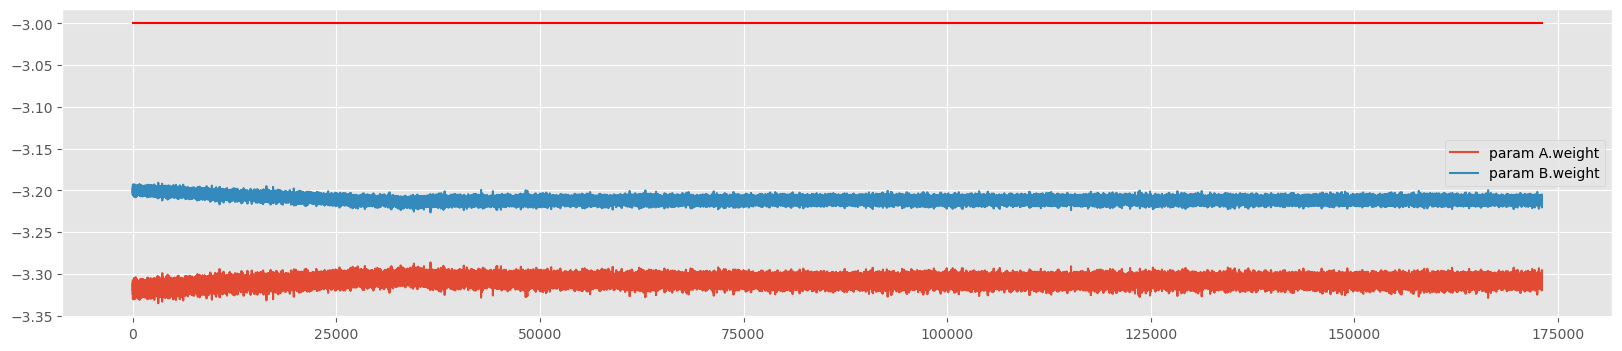

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)

How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.